# GPU checking
For faster Tensorflow use instead of only using CPU

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
# Avoid OOM errors by setting minimum GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Dataset
Gegenava, N. (2022). Musical Instruments - A Global Collection of Iconic Musical Instruments for Image Classification. Kaggle. https://www.kaggle.com/datasets/nikolasgegenava/music-instruments (Accessed on May 26, 2025)

License: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)

In [6]:
from google.colab import drive

drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Colab/P3: Musical Instruments/dataset'

Mounted at /content/drive


# Add images to array lists

In [7]:
import os
import cv2
import numpy as np
import pandas as pd

# Initialize lists (image data, labels, file paths)
all_img_data = []
all_img_labels = []
all_img_paths = []

## 1. Enumerate class names
class_names = sorted(os.listdir(data_dir))
class_map = {name: i for i, name in enumerate(class_names)}

## 2. Start exploring the directory
## Each folder is differentiated by its image class
for folder_name in class_names:
  try:
    folder_path = os.path.join(data_dir, folder_name)

    for img_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, img_name)
      img = cv2.imread(img_path) # Reading image files start here

      # Add to lists (image data, labels, and file paths) if img is readable
      if img is not None:
        all_img_data.append(img)
        all_img_labels.append(class_map[folder_name])
        all_img_paths.append(img_path)

  # Ignore error files/folder
  except Exception as e:
    print(f"Error processing file at {folder_name}: {e}")

## 3. Preview the image data based by its shape, label, and path
dataset_prev = pd.DataFrame({
    'Image shape': [img.shape for img in all_img_data],
    'Label (numerized)': all_img_labels,
    'Label': [class_names[label] for label in all_img_labels],
    'Image Path': all_img_paths
})

dataset_prev

,Image shape,Label (numerized),Label,Image Path
0,"(108, 162, 3)",0,accordion,/content/drive/My Drive/Colab/P3: Musical Inst...
1,"(108, 162, 3)",0,accordion,/content/drive/My Drive/Colab/P3: Musical Inst...
2,"(91, 162, 3)",0,accordion,/content/drive/My Drive/Colab/P3: Musical Inst...
3,"(91, 162, 3)",0,accordion,/content/drive/My Drive/Colab/P3: Musical Inst...
4,"(121, 162, 3)",0,accordion,/content/drive/My Drive/Colab/P3: Musical Inst...
...,...,...,...,...
1801,"(105, 162, 3)",9,violin,/content/drive/My Drive/Colab/P3: Musical Inst...
1802,"(140, 110, 3)",9,violin,/content/drive/My Drive/Colab/P3: Musical Inst...
1803,"(140, 87, 3)",9,violin,/content/drive/My Drive/Colab/P3: Musical Inst...
1804,"(140, 93, 3)",9,violin,/content/drive/My Drive/Colab/P3: Musical Inst...


## Preview Image names by their numerical class

In [ ]:
label_prev = dataset_prev[['Label (numerized)', 'Label']]
label_prev = label_prev.drop_duplicates().reset_index(drop=True)
label_prev

,Label (numerized),Label
0,0,accordion
1,1,banjo
2,2,drum
3,3,flute
4,4,guitar
5,5,harmonica
6,6,saxophone
7,7,sitar
8,8,tabla
9,9,violin


## Plot the images
Preview from each of the image class using plt subplots.

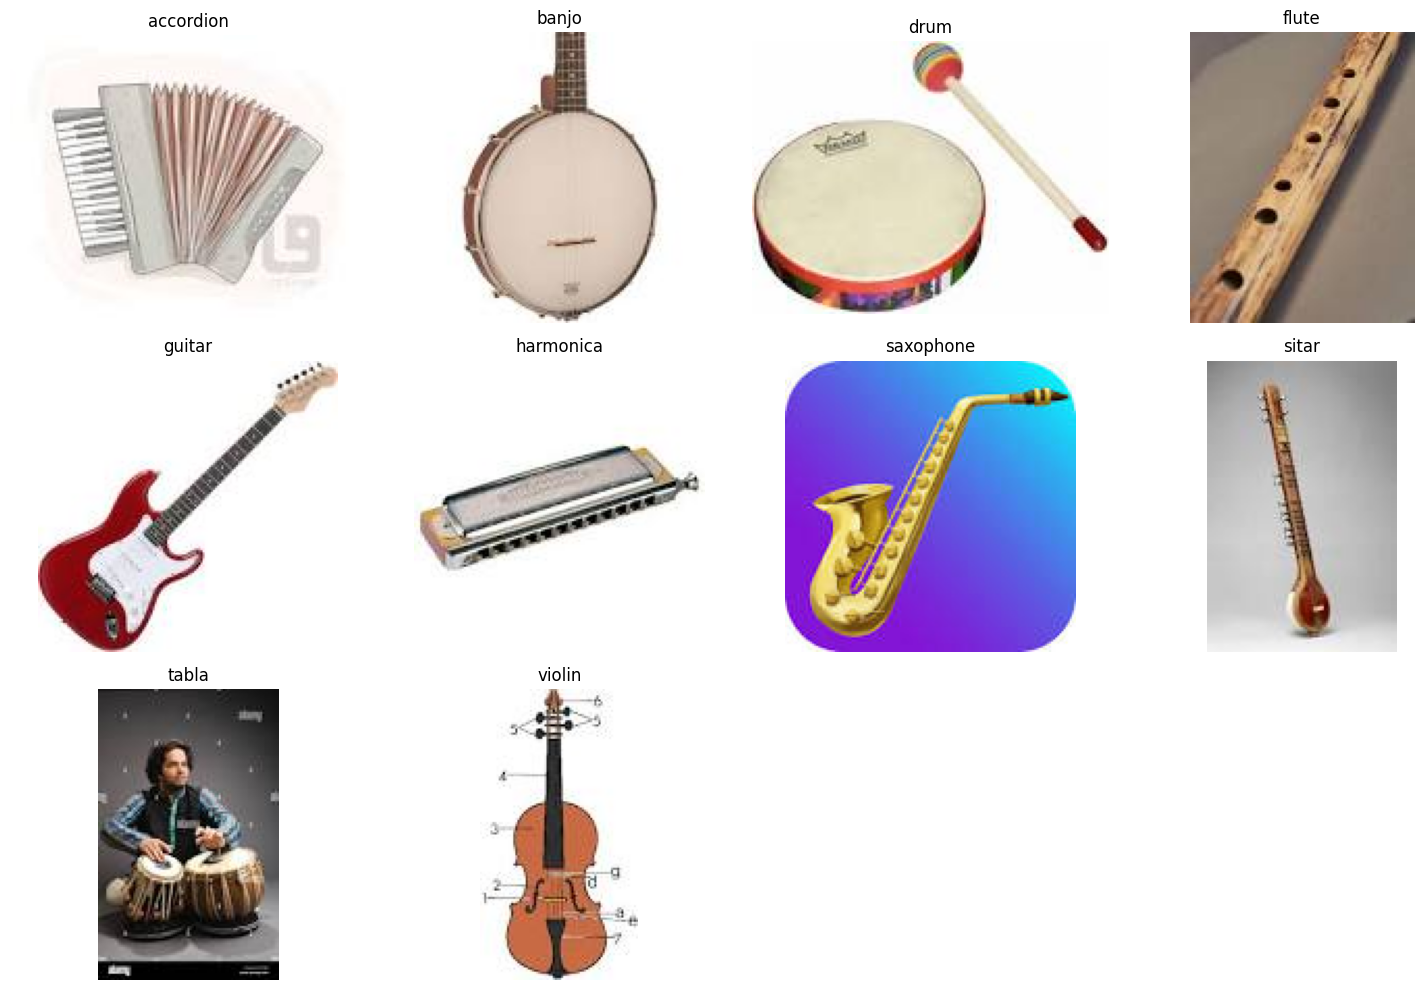

In [10]:
import matplotlib.pyplot as plt
import random
rows = 3
cols = 4

num_classes = len(class_names)
total_subplots = rows * cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Display one random image from each class, up to the total number of subplots
for i in range(min(num_classes, total_subplots)):
    class_index = i
    class_name = class_names[class_index]
    class_image_paths = [path for path in all_img_paths if class_name in path]

    # If there are images for this class, select a random one
    if class_image_paths:
        random_image_path = random.choice(class_image_paths)
        img = cv2.imread(random_image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image in the current subplot
        axes[i].imshow(img_rgb)
        axes[i].set_title(class_name)
        axes[i].axis('off')

# Hide any unused subplots
for j in range(num_classes, total_subplots):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Data Preprocess
Before applying to model, we'll rescale the image to 130x130 (the average width and length of the images) and later standardize the array values.

## Rescale image arrays

In [ ]:
# Scale all img data in "img" to the same size

def rescale_image(image_path, target_size=(130,130)):
  """
  Reads, resizes, and converts an image to a TensorFlow tensor.
  """
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, target_size)
  return img

# Using the rescale_image function
scaled_images = []
for image_path in all_img_paths:
  scaled_img = rescale_image(image_path)
  scaled_images.append(scaled_img)

# Now 'scaled_images' is a list of TensorFlow tensors, all with the same size
# (130, 130, 3) %% Standardize scaled_images data

## Normalize image arrays
Convert arrray values from the range of (0,255) to (0,1)

In [ ]:
# Standardize scaled_images data

scaled_std_imgs = tf.stack(scaled_images)
scaled_std_imgs = scaled_std_imgs / 255.0

rounded_tensor_value = tf.round(scaled_std_imgs[0][0] * 1000) / 1000
print(rounded_tensor_value)

tf.Tensor(
[[0.791 0.791 0.791]
 [0.818 0.818 0.818]
 [0.845 0.845 0.845]
 [0.861 0.861 0.861]
 [0.868 0.868 0.868]
 [0.876 0.876 0.876]
 [0.878 0.878 0.878]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.884 0.884 0.884]
 [0.886 0.886 0.886]
 [0.886 0.886 0.886]
 [0.886 0.886 0.886]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.882 0.882 0.882]
 [0.886 0.886 0.886]
 [0.894 0.894 0.894]
 [0.894 0.894 0.894]
 [0.894 0.894 0.894]
 [0.894 0.894 0.894]
 [0.894 0.894 0.894]
 [0.894 0.894 0.894]
 [0.898 0.898 0.898]
 [0.898 0.898 0.898]
 [0.898 0.898 0.898]
 [0.898 0.898 0.898]
 [0.898 0.898 0.898]
 [0.898 0.898 0.898]
 [0.881 0.881 0.881]
 [0.843 0.843 0.843]
 [0.584 0.584 0.584]
 [0.341 0.341 0.341]
 [0.164 0.164 0.164]
 [0.189 0.189 0.189]
 [0.15  0.15  0.15 ]
 [0.007 0.007 0.007]
 [0.027 0.027 0.027]
 [

# Split Dataset
Into 3 parts:
- Train: 80%
- Valid: 10%
- Test: 10%

In [ ]:
# Splitting into train, valid, and test

from sklearn.model_selection import train_test_split

X = scaled_std_imgs.numpy()
y = all_img_labels

# Split the data into training and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the temporary set into validation and test sets (50% valid, 50% test of the temp set)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {len(y_train)}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_valid: {len(y_valid)}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {len(y_test)}")

Shape of X_train: (1444, 130, 130, 3)
Shape of y_train: 1444
Shape of X_valid: (181, 130, 130, 3)
Shape of y_valid: 181
Shape of X_test: (181, 130, 130, 3)
Shape of y_test: 181


# Build the NN model

Using Conv2D and MaxPooling2D as we're dealing with image arrays.

In [11]:
# Build the NN model using Conv2D and MaxPooling2D

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') # 10 classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,594 (6.48 MB)

 Trainable params: 1,699,594 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

## Apply model to training dataset

In [ ]:
# Train the data using NN model based on X_train and y_train

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Convert y labels to one-hot encoding
y_train_one_hot = tf.one_hot(y_train, depth=10) # Assuming 10 classes
y_valid_one_hot = tf.one_hot(y_valid, depth=10) # Assuming 10 classes

# Create TensorFlow Datasets from the training and validation data
# This is the recommended way to feed data to model.fit() with tf.function
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot)).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_one_hot)).batch(32)


# Train the model using TensorFlow Datasets
hist = model.fit(train_dataset,
                 epochs=20,
                 validation_data=valid_dataset,
                 callbacks=[tensorboard_callback])

## Plotting the iterative loss and accuracy
After 20 epochs, loss is already close to 0 and accuracy is close to 1.

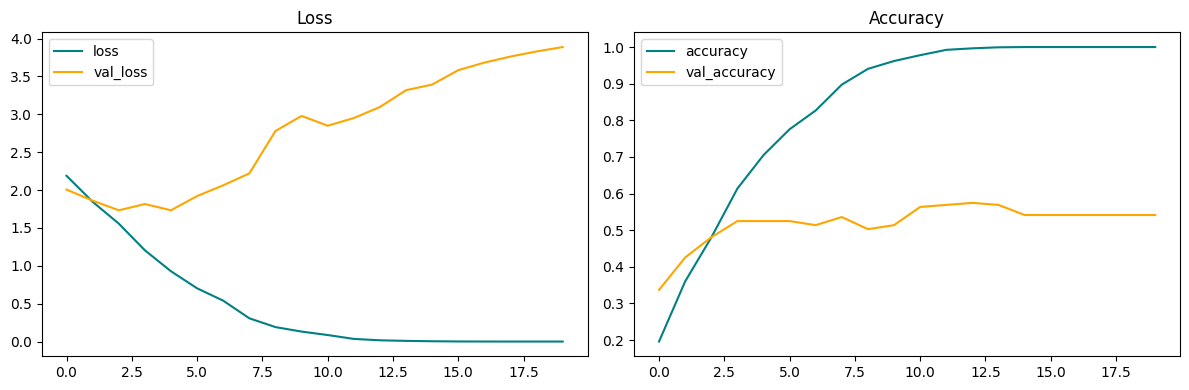

In [ ]:
# Plot the Loss and Accuracy history from hist

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot Loss
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss')
ax[0].legend(loc="upper left")

# Plot Accuracy
ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Model Evaluation
Produced an overall accuracy of 55% after testing the model. We'll also go through each image data using confusion matrix and image preview (from the test dataset).

## Classification report

In [ ]:
# Test the hist tensorflow model and print the classification report
import numpy as np
from sklearn.metrics import classification_report

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
              precision    recall  f1-score   support

           0       0.46      0.61      0.52        18
           1       0.60      0.63      0.62        19
           2       0.57      0.42      0.48        19
           3       0.53      0.56      0.54        18
           4       0.55      0.63      0.59        19
           5       0.74      0.82      0.78        17
           6       0.33      0.24      0.28        17
           7       0.38      0.33      0.35        18
           8       0.59      0.56      0.57        18
           9       0.67      0.67      0.67        18

    accuracy                           0.55       181
   macro avg       0.54      0.55      0.54       181
weighted avg       0.54      0.55      0.54       181



## Comparing Actual vs Predicted
Comparing one-by-one using table:

In [ ]:
# Print the table consisting of Actual test label and Predicted label
results_df = pd.DataFrame({
    'Actual Label': np.array(y_test).flatten(),
    'Predicted Label': np.array(y_pred).flatten()
})

results_df

,Actual Label,Predicted Label
0,8,8
1,2,5
2,5,0
3,6,8
4,1,4
...,...,...
176,4,9
177,6,6
178,3,1
179,7,7


Visualized using confusion matrix:

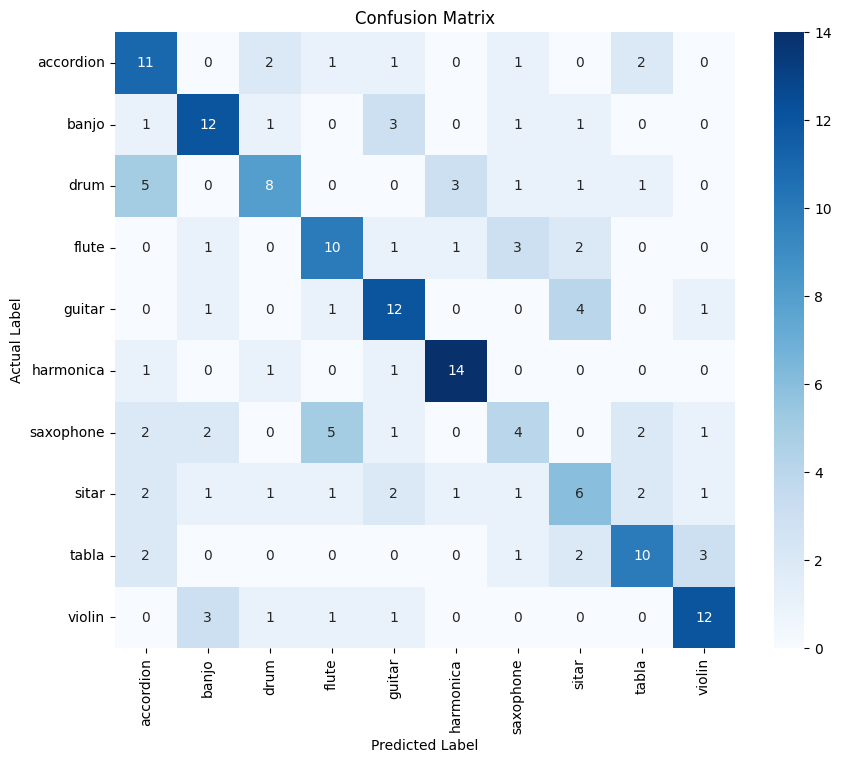

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


Visualized by previewing the images with "Actual" and "Predicted" on the title of each image

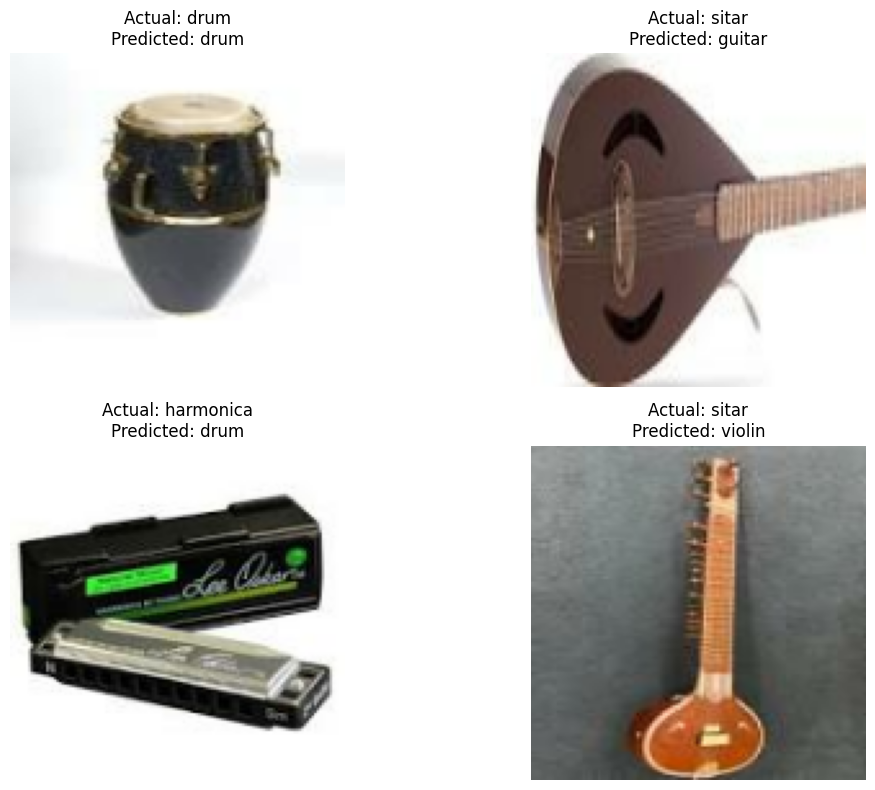

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick 4 random indices from the test set
random_indices = random.sample(range(len(X_test)), 4)

plt.figure(figsize=(12, 8))

for i, index in enumerate(random_indices):
  plt.subplot(2, 2, i + 1)
  # Convert tensor back to image format for displaying
  # Denormalize if necessary (multiply by 255 if it was normalized)
  image_to_display = X_test[index]
  # If the image was normalized by dividing by 255, multiply by 255 to display
  if np.max(image_to_display) <= 1.0:
      image_to_display = image_to_display * 255.0
  image_to_display = image_to_display.astype(np.uint8)


  plt.imshow(image_to_display)
  actual_label = class_names[y_test[index]]
  predicted_label = class_names[y_pred[index]]
  plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
  plt.axis('off')

plt.tight_layout()
plt.show()